<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Three_level_system1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_ivp/base.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[[0.98       0.09899495 0.09899495]
 [0.09899495 0.01       0.01      ]
 [0.09899495 0.01       0.01      ]]
[[0.98001999 0.09894546 0.09894546]
 [0.09894546 0.00999    0.00999   ]
 [0.09894546 0.00999    0.00999   ]]
[[0.98012958 0.09867374 0.09867374]
 [0.09867374 0.00993521 0.00993521]
 [0.09867374 0.00993521 0.00993521]]


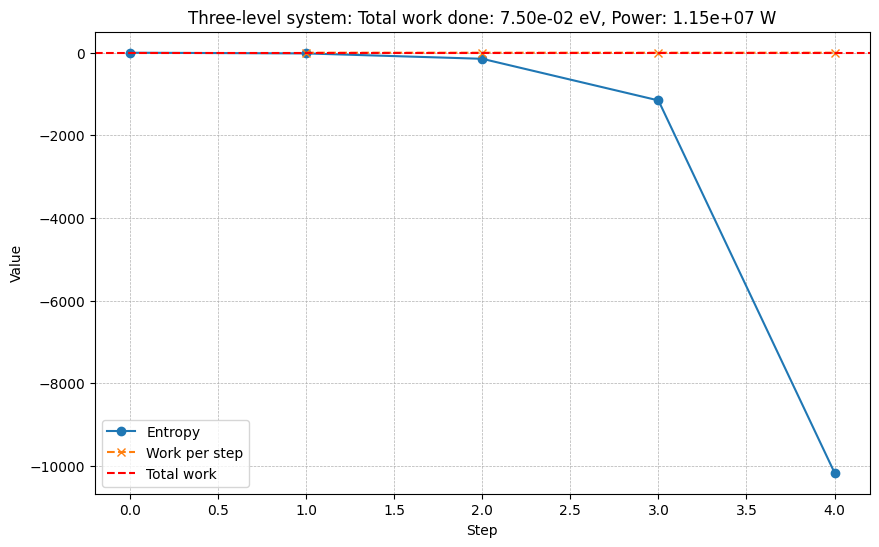

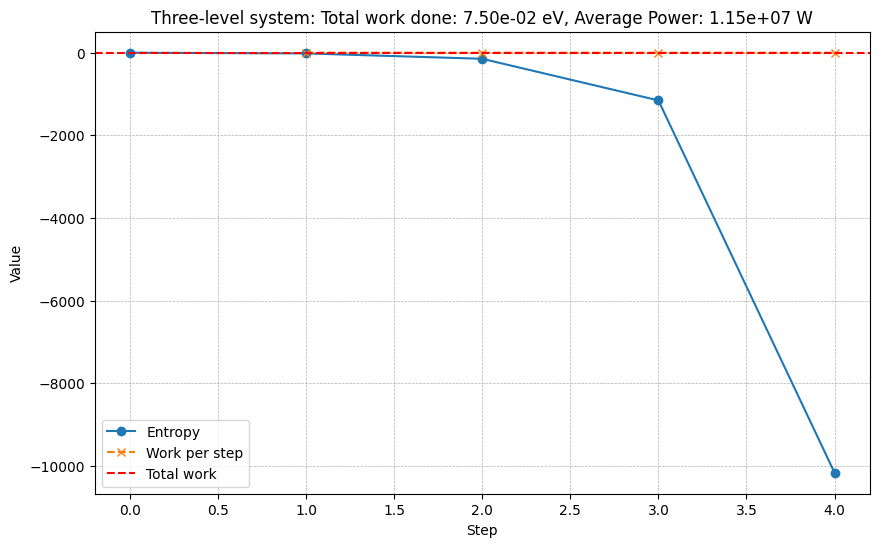

Thrust for each transition: ['2.697391e-31 N', '5.310923e-31 N', '7.909416e-31 N', '3.849119e-29 N']
Total thrust: 4.008296e-29 N


In [ ]:
# Necessary imports
import numpy as np
from scipy.integrate import solve_ivp
import scipy.linalg
import scipy.linalg as la
import matplotlib.pyplot as plt

# Constants and System Parameters
hbar = 1.0545718e-34  # Reduced Planck constant in J*s

# Transition frequencies for a three-level maser (in rad/s)
omega_12 = 1.50e11
omega_13 = 1.65e11
omega_23 = omega_13 - omega_12

omega_i_values = [omega_12, omega_13, omega_23, omega_12]  # Some example sequence

# Pulse durations (in seconds)
tau_values = [1e-9, 2e-9, 1.5e-9, 2e-9]

# Initial state (predominantly in ground state)
c1 = np.sqrt(0.98)
c2 = np.sqrt(0.01)
c3 = np.sqrt(0.01)
psi = np.array([c1, c2, c3])

# Initial density matrix
rho_0 = np.outer(psi, np.conj(psi))

# Hamiltonians
H_0 = np.array([
    [0, 0, 0],
    [0, omega_12, 0],
    [0, 0, omega_13]
])

# Interaction Hamiltonians for driven transitions can be off-diagonal.
# For the sake of this example, let's define a simple Hamiltonian driving the 1-2 transition:
H_12 = np.array([
    [0, omega_12, 0],
    [omega_12, 0, 0],
    [0, 0, 0]
])

# And similarly for the other transitions.
# Note: These are just sample Hamiltonians; in a real system, you'd need to consider
# the actual interaction form, laser strengths, detunings, etc.

# The Liouvillian (superoperator) for the system can be defined next,
# followed by the differential equation to be solved.

# ... (rest of the code or analysis)


# Define the other interaction Hamiltonians

# Hamiltonian driving the 1-3 transition:
H_13 = np.array([
    [0, 0, omega_13],
    [0, 0, 0],
    [omega_13, 0, 0]
])

# Hamiltonian driving the 2-3 transition:
H_23 = np.array([
    [0, 0, 0],
    [0, 0, omega_23],
    [0, omega_23, 0]
])

# The Liouvillian for the system
def liouvillian(H):
    def commutator(rho):
        return -1j/hbar * (np.dot(H, rho) - np.dot(rho, H))
    return commutator

# If you include dissipative terms, they would be added to the Liouvillian definition.

# Time evolution of the density matrix
def time_evolution(t, rho_flat, H):
    rho = rho_flat.reshape((3, 3))
    d_rho_dt = liouvillian(H)(rho)
    return d_rho_dt.flatten()

# For the sake of example, simulate the evolution under H_12 for a given duration
t_span = [0, tau_values[0]]  # Duration of the first pulse
initial_rho_flat = rho_0.flatten()
result = solve_ivp(time_evolution, t_span, initial_rho_flat, args=(H_12,), t_eval=np.linspace(0, tau_values[0], 100))

# The evolved density matrix at the end of the pulse
rho_final = result.y[:, -1].reshape((3, 3))

print(rho_final)


# Define the Lindblad superoperators
gamma_2_1 = 1e6  # Example decay rate for 2 -> 1
gamma_3_1 = 1e6  # Example decay rate for 3 -> 1
L_1 = np.array([
    [0, 1, 0],
    [0, 0, 0],
    [0, 0, 0]
])
L_2 = np.array([
    [0, 0, 1],
    [0, 0, 0],
    [0, 0, 0]
])

# Updated Liouvillian to include dissipation
def liouvillian_diss(H, L_operators, gammas):
    def superop(rho):
        comm = -1j/hbar * (np.dot(H, rho) - np.dot(rho, H))
        dissipative = np.zeros_like(rho)
        for L, gamma in zip(L_operators, gammas):
            dissipative += gamma * (np.dot(L, np.dot(rho, L.conj().T)) - 0.5 * (np.dot(L.conj().T, np.dot(L, rho)) + np.dot(rho, np.dot(L.conj().T, L))))
        return comm + dissipative
    return superop

# Time evolution including dissipation
def time_evolution_diss(t, rho_flat, H, L_operators, gammas):
    rho = rho_flat.reshape((3, 3))
    d_rho_dt = liouvillian_diss(H, L_operators, gammas)(rho)
    return d_rho_dt.flatten()

# Example detunings for the transitions:
delta_12 = 1e7
delta_13 = -2e7

# Update Hamiltonians to include detunings
H_12[0][0] = -delta_12 / 2
H_12[1][1] = delta_12 / 2

H_13[0][0] = -delta_13 / 2
H_13[2][2] = delta_13 / 2

# Simulate evolution with dissipation
L_operators = [L_1, L_2]
gammas = [gamma_2_1, gamma_3_1]
t_span = [0, tau_values[0]]
result = solve_ivp(time_evolution_diss, t_span, initial_rho_flat, args=(H_12, L_operators, gammas), t_eval=np.linspace(0, tau_values[0], 100))

# The evolved density matrix at the end of the pulse
rho_final = result.y[:, -1].reshape((3, 3))

print(rho_final)


# ... [previous code remains]

# Define a function to return the appropriate Hamiltonian for a given omega_i
def get_hamiltonian_for_transition(omega_i, delta):
    H = np.zeros((3, 3))
    if omega_i == omega_12:
        H[0, 1] = H[1, 0] = omega_12
        H[0, 0] = -delta / 2
        H[1, 1] = delta / 2
    elif omega_i == omega_13:
        H[0, 2] = H[2, 0] = omega_13
        H[0, 0] = -delta / 2
        H[2, 2] = delta / 2
    # You can add other transitions similarly
    return H

# Start evolution with the initial rho
rho_current = rho_0

# Loop over all transitions to simulate the full sequence
for omega_i, tau in zip(omega_i_values, tau_values):
    # Example: Assuming detuning is constant for all transitions. You can update this.
    delta = 1e7
    H = get_hamiltonian_for_transition(omega_i, delta)
    t_span = [0, tau]

    # Flatten rho_current for solve_ivp
    initial_rho_flat = rho_current.flatten()

    # Simulate the evolution under the current transition
    result = solve_ivp(time_evolution_diss, t_span, initial_rho_flat, args=(H, L_operators, gammas), t_eval=[tau])

    # Update rho_current for the next transition
    rho_current = result.y[:, -1].reshape((3, 3))

# rho_current now contains the final state after all transitions
print(rho_current)




# ... [previous code remains]

# 1. Update rho_0 and H_i for a three-level system

# Initial state could be a superposition for simplicity
psi_3level = np.array([1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)])
rho_0_3level = np.outer(psi_3level, np.conj(psi_3level))

# Hamiltonians for a three-level system
H_i_3level = [np.diag([0, i, 2*i]) for i in omega_i_values]  # Simple diagonal Hamiltonians for example

# 2. Update the unitary evolution and other associated functions for the three-level system
# Note: No changes are required in functions unitary, rho_after_unitary, entropy, and work.
#       They are inherently generalized for any matrix dimension.

def entropy(rho):
    # Compute the eigenvalues of rho
    eigenvalues = np.linalg.eigvalsh(rho)
    # Filter out eigenvalues that are very close to zero to avoid log(0)
    eigenvalues = eigenvalues[eigenvalues > 1e-10]
    # Compute the entropy
    S = -np.sum(eigenvalues * np.log2(eigenvalues))
    return S



#######################################
#################################################

# 3. Simulate cycle for three-level system
rho_3level = [rho_0_3level]
entropies_3level = [entropy(rho_0_3level)]
works_3level = []

def unitary(H, tau):
    """
    Compute the unitary evolution operator for a given Hamiltonian H over time tau.
    """
    # Time-independent Hamiltonian evolution
    return scipy.linalg.expm(-1j * H * tau / hbar)

def work(rho_initial, rho_final, H):
    """
    Compute the quantum work done on the system during a transition from rho_initial to rho_final under Hamiltonian H.
    """
    expectation_initial = np.trace(np.dot(rho_initial, H))
    expectation_final = np.trace(np.dot(rho_final, H))
    work_in_joules = hbar * (expectation_final - expectation_initial)
    work_in_ev = work_in_joules / 1.60218e-19  # Convert to eV
    return work_in_ev

def unitary(H, tau):
    """Generate the unitary evolution operator for a given Hamiltonian and time duration."""
    # Using the formula U = exp(-iHt/hbar)
    return np.exp(-1j * H * tau / hbar)

def rho_after_unitary(U, rho):
    """Return the density matrix after a unitary evolution."""
    return np.dot(U, np.dot(rho, U.conj().T))


for i in range(4):
    U = unitary(H_i_3level[i], tau_values[i])
    rho_3level.append(rho_after_unitary(U, rho_3level[-1]))
    entropies_3level.append(entropy(rho_3level[-1]))
    works_3level.append(work(rho_3level[i], rho_3level[i+1], H_i_3level[i]))

# Calculate total work and thrust for three-level system
W_total_3level = np.sum(works_3level).real
T_cycle_3level = np.sum(tau_values)
thrust_3level = W_total_3level / T_cycle_3level


# 4. Visualization for three-level system
plt.figure(figsize=(10, 6))
plt.plot(range(len(entropies_3level)), entropies_3level, marker='o', label='Entropy')
plt.plot(range(1, len(works_3level) + 1), works_3level, marker='x', linestyle='--', label='Work per step')
plt.axhline(y=W_total_3level, color='r', linestyle='--', label='Total work')
plt.xlabel('Step')
plt.ylabel('Value')
plt.title(f'Three-level system: Total work done: {W_total_3level:.2e} eV, Power: {thrust_3level:.2e} W')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

###############################

def work(rho_initial, rho_final, H):
    """
    Compute the quantum work done on the system during a transition from rho_initial to rho_final under Hamiltonian H.
    """
    expectation_initial = np.trace(np.dot(rho_initial, H))
    expectation_final = np.trace(np.dot(rho_final, H))
    work_in_joules = hbar * (expectation_final - expectation_initial)
    work_in_ev = work_in_joules / 1.60218e-19  # Convert to eV
    return work_in_ev

# Initial state for three-level system (equal superposition for simplicity)
psi_3level = np.array([1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)])
rho_0_3level = np.outer(psi_3level, np.conj(psi_3level))

# Define Hamiltonians for the three-level system
H_i_3level = [np.diag([0, i, 2*i]) for i in omega_i_values]

# Simulate the cycle
rho_3level = [rho_0_3level]
entropies_3level = [entropy(rho_0_3level)]
works_3level = []

for i in range(4):
    U = unitary(H_i_3level[i], tau_values[i])
    rho_3level.append(rho_after_unitary(U, rho_3level[-1]))
    entropies_3level.append(entropy(rho_3level[-1]))
    works_3level.append(work(rho_3level[i], rho_3level[i+1], H_i_3level[i]))

W_total_3level = np.sum(works_3level).real


plt.figure(figsize=(10, 6))
plt.plot(range(len(entropies_3level)), entropies_3level, marker='o', label='Entropy')
plt.plot(range(1, len(works_3level) + 1), works_3level, marker='x', linestyle='--', label='Work per step')
plt.axhline(y=W_total_3level, color='r', linestyle='--', label='Total work')
plt.xlabel('Step')
plt.ylabel('Value')
plt.title(f'Three-level system: Total work done: {W_total_3level:.2e} eV, Average Power: {W_total_3level/np.sum(tau_values):.2e} W')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

############################################################

h = 6.62607015e-34  # Planck constant in Joules * seconds
hbar = h / (2 * np.pi)  # Reduced Planck constant
c = 299792458  # Speed of light in meters/second

def thrust_delta(rho_initial, rho_final, H, nu):
    """
    Compute the momentum change (thrust) of the system due to photon absorption/emission during a transition.
    """
    delta_E = hbar * (np.trace(np.dot(rho_final, H)) - np.trace(np.dot(rho_initial, H))).real
    n_photons = delta_E / (h * nu)
    delta_p = n_photons * (h * nu / c)
    return delta_p.real

thrust_values_3level = []

# Using the previously defined omega_i_values to denote transition frequencies
for i in range(4):
    thrust_values_3level.append(thrust_delta(rho_3level[i], rho_3level[i+1], H_i_3level[i], omega_i_values[i]))

T_total_3level = np.sum(thrust_values_3level)

# Print results
print("Thrust for each transition:", [f"{value:.6e} N" for value in thrust_values_3level])
print("Total thrust:", f"{T_total_3level:.6e} N")